https://github.com/pymc-devs/pymc3/issues/3012

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 469.51draws/s]


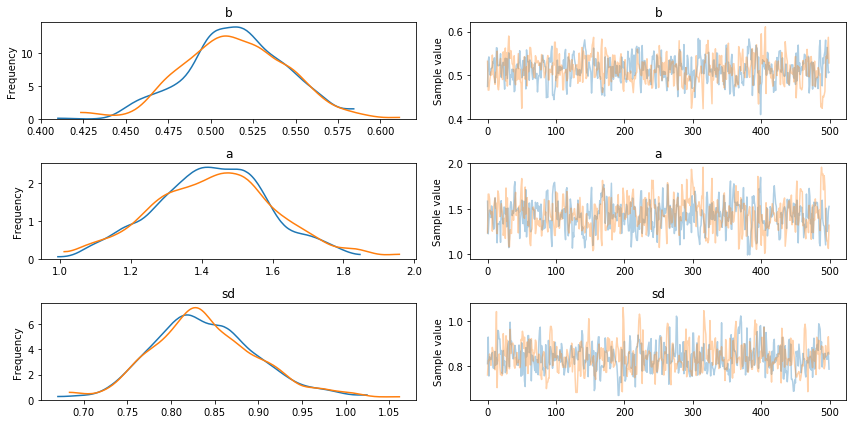

In [18]:
X = np.random.uniform(0., 10., size=100)
y = X*.5 + 1.5 + np.random.randn(100)*.8

with pm.Model() as m:
    X_ = pm.Uniform('x', 0., 10., observed=X)
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs', a+b*X_, sd, observed=y)
    trace = pm.sample()

pm.traceplot(trace);

In [3]:
with m:
    ppc = pm.sample_ppc(trace, 200)

100%|██████████| 200/200 [00:00<00:00, 339.74it/s]


In [22]:
ppc['x'].shape, ppc['obs'].shape

((200, 100), (200, 100))

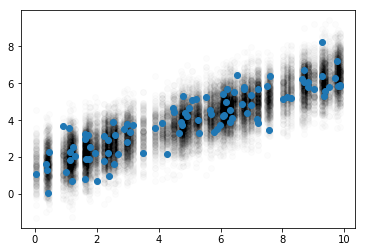

In [23]:
plt.plot(X, ppc['obs'].T, 'ko', alpha=.01);
plt.plot(X, y, 'o');

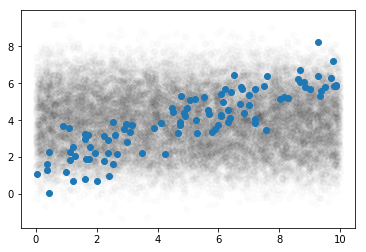

In [24]:
plt.plot(ppc['x'].T, ppc['obs'].T, 'ko', alpha=.01);
plt.plot(X, y, 'o');

In [8]:
with pm.Model() as m2:
    X_ = pm.Uniform('x', 0., 10., shape=X.shape)
    pm.Normal('obs1', X_, .01, observed=X)
    
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs2', a+b*X_, sd, observed=y)
    trace1 = pm.sample()
    ppc = pm.sample_ppc(trace1, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b, x]
100%|██████████| 200/200 [00:00<00:00, 470.96it/s]


In [9]:
ppc['obs1'].shape, ppc['obs2'].shape

((200, 100), (200, 100))

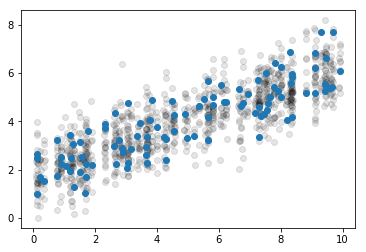

In [10]:
ind = slice(0, 10)
plt.plot(ppc['obs1'][ind,:], ppc['obs2'][ind,:], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [25]:
with m:
    Xnew = pm.Uniform('xnew', 0., 10.)
    Ynew = pm.Normal('ynew', a+b*Xnew, sd)
    ppc = pm.sample_ppc(trace, 200, vars=[Xnew, Ynew])

100%|██████████| 200/200 [00:09<00:00, 20.56it/s]


In [26]:
ppc['xnew'].shape, ppc['ynew'].shape

((200,), (200,))

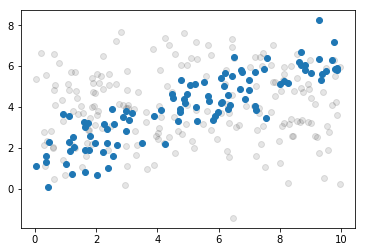

In [27]:
plt.plot(ppc['xnew'], ppc['ynew'], 'ko', alpha=.1);
plt.plot(X, y, 'o');